# Analyzing BYOL-A features: How is the partial dimensional collapse in the pre-trained BYOL-A representation?

Are some of the dimensions in a BYOL-A feature collapse? I checked with the FSD50K samples.

- [1] Li et al., "Understanding Collapse in Non-Contrastive Siamese Representation Learning," in ECCV, 2022, https://arxiv.org/abs/2209.15007, https://link.springer.com/chapter/10.1007/978-3-031-19821-2_28
- [2] Fonseca et al., “FSD50K: an Open Dataset of Human-Labeled Sound Events,” IEEE TASLP 2021, https://arxiv.org/abs/2010.00475, https://ieeexplore.ieee.org/document/9645159
- [3] Niizumi et al., "BYOL for Audio: Self-Supervised Learning for General-Purpose Audio Representation," IJCNN 2021, https://arxiv.org/abs/2103.06695, https://ieeexplore.ieee.org/document/9534474

In [1]:
from dlcliche.notebook import *
from dlcliche.torch_utils import *

Prepare a BYOL-A instance.

In [2]:
BYOLA = '/lab/byol-a'
sys.path.append(BYOLA)

from byol_a.common import *
from byol_a.augmentations import PrecomputedNorm
from byol_a.models import AudioNTT2020
import torchaudio


device = torch.device('cpu')
cfg = load_yaml_config(BYOLA + '/config.yaml')
print(cfg)

# ** Prepare the statistics in advance **
# You need to calculate the statistics of mean and standard deviation of the log-mel spectrogram of your dataset.
# See calc_norm_stats in evaluate.py for your reference.
stats = [-5.4919195,  5.0389895]

# Preprocessor and normalizer.
to_melspec = torchaudio.transforms.MelSpectrogram(
    sample_rate=cfg.sample_rate,
    n_fft=cfg.n_fft,
    win_length=cfg.win_length,
    hop_length=cfg.hop_length,
    n_mels=cfg.n_mels,
    f_min=cfg.f_min,
    f_max=cfg.f_max,
)
normalizer = PrecomputedNorm(stats)

# Load pretrained weights.
model = AudioNTT2020(d=cfg.feature_d)
model.load_weight(BYOLA + '/pretrained_weights/AudioNTT2020-BYOLA-64x96d2048.pth', device)

# Load your audio file.
wav, sr = torchaudio.load(BYOLA + '/work/16k/spcv2/one/00176480_nohash_0.wav') # a sample from SPCV2 for now
assert sr == cfg.sample_rate, "Let's convert the audio sampling rate in advance, or do it here online."

# Convert to a log-mel spectrogram, then normalize.
lms = normalizer((to_melspec(wav) + torch.finfo(torch.float).eps).log())

# Now, convert the audio to the representation.
features = model(lms.unsqueeze(0))

print(features.shape)

{'unit_sec': 0.95, 'sample_rate': 16000, 'n_fft': 1024, 'win_length': 1024, 'hop_length': 160, 'n_mels': 64, 'f_min': 60, 'f_max': 7800, 'feature_d': 2048, 'proj_size': 256, 'proj_dim': 4096, 'ema_decay': 0.99, 'seed': 42, 'bs': 256, 'lr': 0.0003, 'epochs': 100, 'gpus': 1, 'num_workers': 8, 'resume': None, 'shape': [64, 96], 'checkpoint_folder': 'checkpoints'}
torch.Size([1, 2048])


In [3]:
fsd50k_files = sorted(Path(BYOLA + '/work/16k/fsd50k/FSD50K.dev_audio').glob('*.wav'))
random.shuffle(fsd50k_files)

N = 10000
features = []
for fpath in fsd50k_files[:N]:
    wav, sr = torchaudio.load(fpath)
    assert sr == cfg.sample_rate, "Let's convert the audio sampling rate in advance, or do it here online."
    with torch.no_grad():
        lms = normalizer((to_melspec(wav) + torch.finfo(torch.float).eps).log())
        features.append(model(lms.unsqueeze(0)))
features = torch.vstack(features)
features.shape

torch.Size([10000, 2048])

In [4]:
import analyze_repr

print(analyze_repr.get_cumulative_explained_variance_auc(features))

tensor(0.7983)


torch.Size([2048]) torch.Size([]) torch.Size([2048])


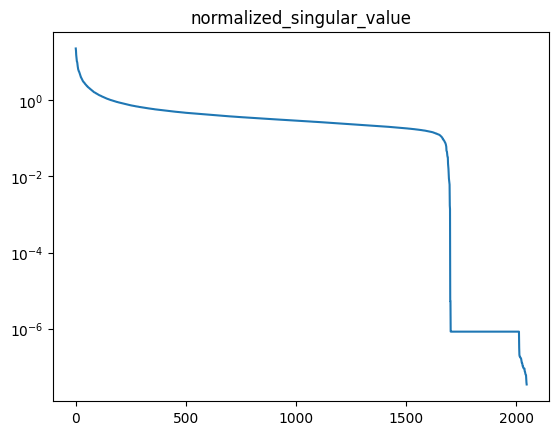

tensor(0.7983)


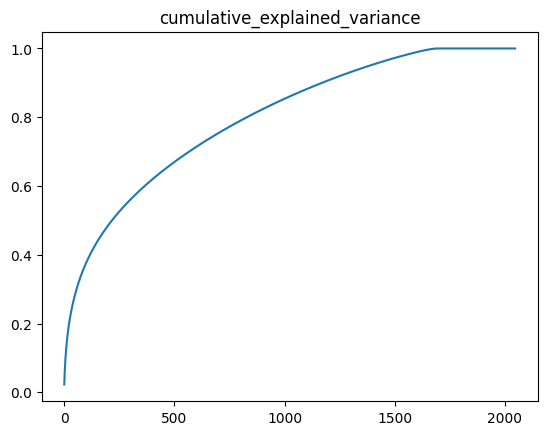

In [5]:
nsv = analyze_repr.normalized_singular_value(features)
auc, cev = analyze_repr.cumulative_explained_variance(nsv)
print(nsv.shape, auc.shape, cev.shape)

plt.plot(nsv.cpu().numpy())
plt.title('normalized_singular_value')
plt.yscale('log')
plt.show()

print(auc)
plt.plot(cev.numpy())
plt.title('cumulative_explained_variance')
plt.show()

## How many are the feature dimensions collapsed?

In [6]:
collapse_ratio = sum(nsv < 1e-4) / nsv.shape[0]
print(f'{collapse_ratio * 100:.4} % of the feature dimensions are just zero.')

16.99 % of the feature dimensions are just zero.


## Failure case: The smaller samples will show a large collapse.

Use enough samples, such as 10,000 (found this number empirically; please check with your data), or you will see many collapsed dimensions.

torch.Size([2048]) torch.Size([]) torch.Size([2048])


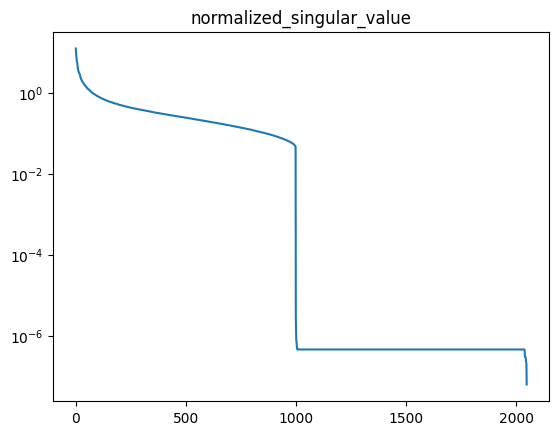

tensor(0.8921)


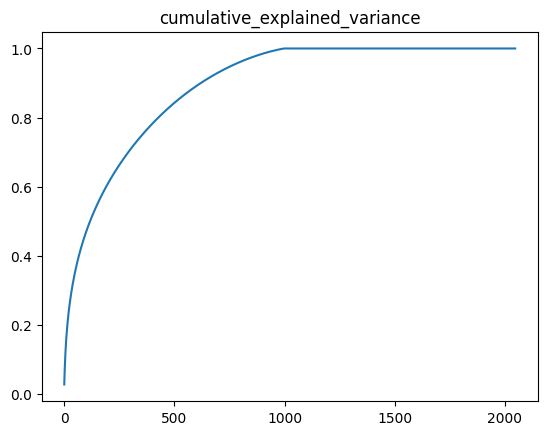

51.22 % of the feature dimensions are just zero.


In [10]:
fsd50k_files = sorted(Path(BYOLA + '/work/16k/fsd50k/FSD50K.dev_audio').glob('*.wav'))
random.shuffle(fsd50k_files)

N = 1000
features = []
for fpath in fsd50k_files[N:N*2]:
    wav, sr = torchaudio.load(fpath)
    assert sr == cfg.sample_rate, "Let's convert the audio sampling rate in advance, or do it here online."
    with torch.no_grad():
        lms = normalizer((to_melspec(wav) + torch.finfo(torch.float).eps).log())
        features.append(model(lms.unsqueeze(0)))
features = torch.vstack(features)

# Ensuring the number of samples is greater than that of dimensions.
features = torch.vstack([features, features, features])

nsv = analyze_repr.normalized_singular_value(features)
auc, cev = analyze_repr.cumulative_explained_variance(nsv)
print(nsv.shape, auc.shape, cev.shape)

plt.plot(nsv.cpu().numpy())
plt.title('normalized_singular_value')
plt.yscale('log')
plt.show()

print(auc)
plt.plot(cev.numpy())
plt.title('cumulative_explained_variance')
plt.show()

collapse_ratio = sum(nsv < 1e-4) / nsv.shape[0]
print(f'{collapse_ratio * 100:.4} % of the feature dimensions are just zero.')

### More number of samples show a larger collapse

The result with 20,000 samples is almost close to that with 10,000 samples above; That with 20K is almost saturated.

In [8]:
fsd50k_files = sorted(Path(BYOLA + '/work/16k/fsd50k/FSD50K.dev_audio').glob('*.wav'))
random.shuffle(fsd50k_files)

N = 20000
features = []
for fpath in fsd50k_files[N:N*2]:
    wav, sr = torchaudio.load(fpath)
    assert sr == cfg.sample_rate, "Let's convert the audio sampling rate in advance, or do it here online."
    with torch.no_grad():
        lms = normalizer((to_melspec(wav) + torch.finfo(torch.float).eps).log())
        features.append(model(lms.unsqueeze(0)))
features = torch.vstack(features)

print(analyze_repr.get_cumulative_explained_variance_auc(features))

tensor(0.7939)


torch.Size([2048]) torch.Size([]) torch.Size([2048])


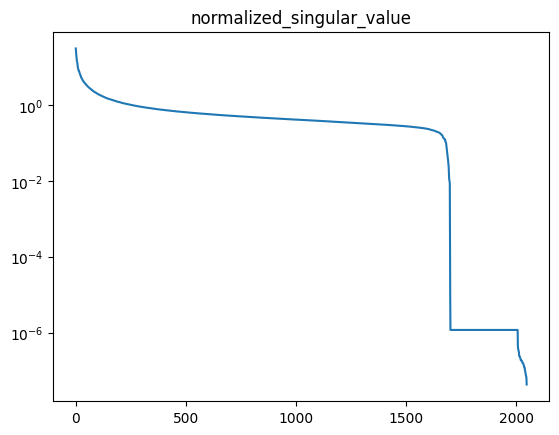

tensor(0.7939)


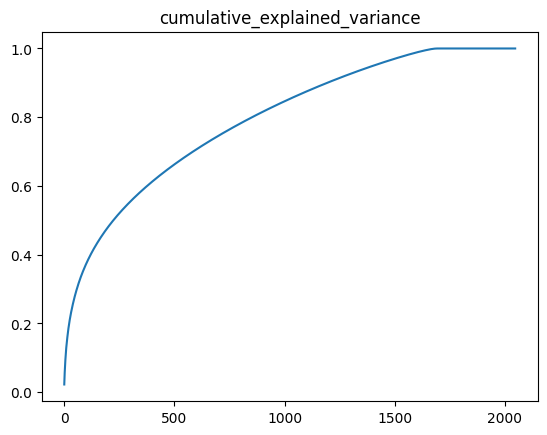

17.04 % of the feature dimensions are just zero.


In [9]:
nsv = analyze_repr.normalized_singular_value(features)
auc, cev = analyze_repr.cumulative_explained_variance(nsv)
print(nsv.shape, auc.shape, cev.shape)

plt.plot(nsv.cpu().numpy())
plt.title('normalized_singular_value')
plt.yscale('log')
plt.show()

print(auc)
plt.plot(cev.numpy())
plt.title('cumulative_explained_variance')
plt.show()

collapse_ratio = sum(nsv < 1e-4) / nsv.shape[0]
print(f'{collapse_ratio * 100:.4} % of the feature dimensions are just zero.')